In [35]:
import pandas as pd
import datetime
import random
import pytz

from sqlalchemy import create_engine

from password import hoop_pwd
pwd = hoop_pwd.password

%matplotlib inline

from nba_seer import *

In [2]:
# create sql conn and load game stats logs ----------------------

conn = create_engine('mysql+pymysql://root:%s@118.190.202.87:3306/nba_stats' % pwd)
game_stats_logs = pd.read_sql_table('game_stats_logs', conn)
game_stats_logs = game_stats_logs[game_stats_logs['GAME_TYPE'] != 'all_star']

print(str(len(game_stats_logs)) + ' player stats loaded.')

184764 player stats loaded.


In [3]:
# load player list ----------------------

all_players = nba_py.player.PlayerList(season='2017-18').info()

print('players list loaded')

players list loaded


In [4]:
def get_score(row):
    player_id = row['PERSON_ID']
    game_id = row['GAME_ID']
    stats = game_stats_logs[(game_stats_logs['PLAYER_ID'] == player_id) & 
                            (game_stats_logs['GAME_ID'] == game_id)].copy()
    #print(stats)
    stats['SCO'] = stats['PTS'] * 1 + stats['AST'] * 1.5 + \
    stats['OREB'] * 1 + stats['DREB'] * 0.7 + \
    stats['STL'] * 2 + stats['BLK'] * 1.8 + stats['TO'] * -1 + \
    stats['FGM'] * 0.4 + (stats['FGA'] - stats['FGM']) * -1 + stats['FG3M'] * 0.5
    return stats['SCO'].max()

In [42]:
def test_result(players):
    diff_pct = players['SCO_DIFF_PCT'].describe().to_frame()
    diff_sco = players['SCO_DIFF'].describe().to_frame()
    ans = pd.concat([diff_sco, diff_pct], axis=1)
    return ans

In [43]:
def factor_cov(players):
    cov_diff = pd.DataFrame()
    #cov_diff['cov'] = abs(players[['MIN_COV_20', 'SCO_COV_20']].mean(axis = 1))
    cov_diff['cov'] = abs(players['MIN_COV_20'] * players['SCO_COV_20'])
    cov_diff['diff_pct'] = abs(players['SCO_DIFF_PCT'])
    cov_diff.plot(x='cov', y='diff_pct', kind='scatter', grid=True, figsize=(10, 7))
    cov_diff_pct_corr = cov_diff['cov'].corr(cov_diff['diff_pct'])
    return cov_diff_pct_corr

In [5]:
game_date = game_stats_logs['GAME_DATE_EST'].drop_duplicates().apply(lambda x: x[:10])

In [8]:
players = pd.DataFrame()
for i in random.sample(list(game_date), 5):
    j = datetime.datetime.strptime(i, "%Y-%m-%d").date()
    games = get_games(j)
    players = players.append(get_players_p(games, game_stats_logs))
    print(str(j) + ' complete!')
else:
    print(len(players), ' players total!')

2017-02-23 complete!
2017-04-30 complete!
2012-12-08 complete!
2013-04-01 complete!
2017-02-01 complete!
968  players total!


In [9]:
players = get_exp_sco(players, game_stats_logs)

players['ACT_SCO'] = players.apply(get_score, axis = 1)
players['SCO_DIFF'] = players['EXP_SCO'] - players['ACT_SCO']
players['SCO_DIFF_PCT'] = players['SCO_DIFF'] / players['ACT_SCO']
print('test data loaded!')

5games days complete!
days rest complete!
ma20 complete!
ma10 complete!
ma5 complete!
min20 complete!
min10 complete!
min5 complete!
min_cov_20 complete!
sco_cov_20 complete!
sco cov less than 0 droped!
all done!
test data loaded!


In [10]:
players = players[(players['ACT_SCO'] != 0) & (players['ACT_SCO'].notnull())]

In [66]:
players.sort_values('ACT_SCO')

,PERSON_ID,TEAM_ID,Location,GAME_ID,Against_Team_ID,5_g_d,d_rest,MA_20,MA_10,MA_5,MIN_20,MIN_10,MIN_5,MIN_COV_20,SCO_COV_20,EXP_SCO,ACT_SCO,SCO_DIFF,SCO_DIFF_PCT
164,201960,1610612762,HOME,0021201106,1610612757,16.0,1663.0,19.61,9.50,14.72,14.72,8.90,3.81,0.656,0.911,3.71,-4.3,8.01,-1.862791
256,1627734,1610612760,HOME,0021600740,1610612741,8.0,255.0,13.74,11.79,12.20,23.03,23.80,27.21,0.240,0.672,8.62,-3.8,12.42,-3.268421
44,1627739,1610612750,AWAY,0021600731,1610612739,8.0,256.0,15.59,14.57,18.92,17.24,17.84,21.39,0.355,0.842,8.55,-3.0,11.55,-3.850000
114,201601,1610612746,AWAY,0021600854,1610612744,9.0,240.0,14.95,13.57,12.35,21.15,17.53,22.78,0.364,0.626,7.75,-2.6,10.35,-3.980769
238,202688,1610612756,HOME,0021600739,1610612746,8.0,256.0,19.18,13.62,15.06,17.79,18.75,21.48,0.424,0.879,8.57,-2.2,10.77,-4.895455
113,1627362,1610612744,HOME,0021600854,1610612746,7.0,240.0,10.40,9.58,0.88,13.87,15.39,8.13,0.825,1.608,2.41,-2.0,4.41,-2.205000
95,2863,1610612755,AWAY,0021200285,1610612738,13.0,1771.0,8.97,11.26,27.43,7.42,6.94,11.50,0.818,1.940,3.80,-2.0,5.80,-2.900000
124,203117,1610612753,AWAY,0021201104,1610612745,8.0,1658.0,12.41,19.08,19.85,7.06,6.20,6.65,0.536,1.968,3.15,-2.0,5.15,-2.575000
96,1627758,1610612752,AWAY,0021600733,1610612751,12.0,255.0,18.98,12.53,10.22,14.41,17.04,16.09,0.601,1.054,6.12,-2.0,8.12,-4.060000
156,201959,1610612741,HOME,0021200288,1610612752,9.0,1771.0,19.42,17.61,13.99,20.43,20.43,19.90,0.211,0.432,9.57,-1.6,11.17,-6.981250


In [82]:
players_t = players[players['5_g_d'] < 20]
players_t = players_t[players_t['SCO_COV_20'] < 0.6]
players_t = players_t[players_t['MIN_COV_20'] < 0.25]
players_t.sort_values('ACT_SCO')

,PERSON_ID,TEAM_ID,Location,GAME_ID,Against_Team_ID,5_g_d,d_rest,MA_20,MA_10,MA_5,MIN_20,MIN_10,MIN_5,MIN_COV_20,SCO_COV_20,EXP_SCO,ACT_SCO,SCO_DIFF,SCO_DIFF_PCT
156,201959,1610612741,HOME,0021200288,1610612752,9.0,1771.0,19.42,17.61,13.99,20.43,20.43,19.90,0.211,0.432,9.57,-1.6,11.17,-6.981250
28,201985,1610612764,HOME,0021200283,1610612744,11.0,1771.0,18.72,19.09,21.22,29.22,26.65,28.25,0.193,0.541,15.33,-1.5,16.83,-11.220000
133,2557,1610612750,HOME,0021201105,1610612738,6.0,1658.0,18.50,17.99,19.34,30.83,28.72,28.41,0.124,0.441,15.16,0.6,14.56,24.266667
183,201599,1610612746,HOME,0021201107,1610612754,7.0,1658.0,25.02,24.87,26.54,23.42,25.64,28.21,0.242,0.357,18.23,0.8,17.43,21.787500
121,202329,1610612740,AWAY,0021200286,1610612748,9.0,1773.0,19.05,13.60,14.37,31.19,30.88,28.88,0.244,0.498,13.20,1.4,11.80,8.428571
183,202347,1610612763,HOME,0021200289,1610612737,9.0,1771.0,16.21,14.51,15.70,24.07,25.78,28.09,0.221,0.547,11.17,1.4,9.77,6.978571
84,203930,1610612751,HOME,0021600733,1610612752,7.0,256.0,18.94,17.54,20.97,25.22,24.50,24.36,0.205,0.543,13.14,1.5,11.64,7.760000
135,201978,1610612750,HOME,0021201105,1610612738,6.0,1658.0,21.55,20.41,18.66,21.76,20.33,21.68,0.177,0.504,11.93,2.4,9.53,3.970833
6,202687,1610612753,HOME,0021600730,1610612754,8.0,256.0,21.03,21.63,19.94,20.69,18.82,18.80,0.211,0.568,11.27,3.1,8.17,2.635484
48,200809,1610612739,AWAY,0021201101,1610612737,7.0,1659.0,6.47,6.47,6.47,14.10,14.10,14.10,0.244,0.497,2.53,3.2,-0.67,-0.209375


In [83]:
test_result(players_t)

,SCO_DIFF,SCO_DIFF_PCT
count,307.000000,307.000000
mean,-0.006515,0.439779
std,10.433917,2.331807
min,-31.110000,-11.220000
25%,-6.135000,-0.245934
50%,0.710000,0.030986
75%,7.160000,0.457940
max,27.990000,24.266667


0.09136224007434926

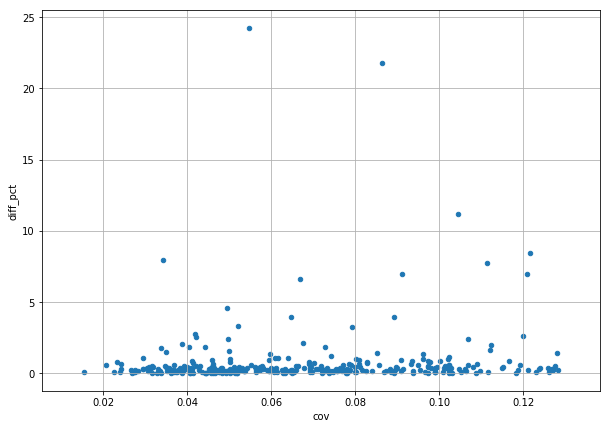

In [84]:
factor_cov(players_t)